# Winery classification using the one-dimensional Gaussian

The **Wine** data set is the running example for our discussion of the *generative approach to classification*.

The data can be downloaded from the UCI repository (https://archive.ics.uci.edu/ml/datasets/wine). It contains 178 labeled data points, each corresponding to a bottle of wine:
* The features (`x`): a 13-dimensional vector consisting of visual and chemical features for the bottle of wine
* The label (`y`): the winery from which the bottle came (1,2,3)

Before continuing, download the data set and place it in the same directory as this notebook.

## 1. Load in the data set

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive/Colab Notebooks/UCSanDiegoX DSE220x Machine Learning Fundamentals/winery-univariate"
local_folder = "/content/drive/MyDrive/Colab Notebooks/UCSanDiegoX DSE220x Machine Learning Fundamentals/winery-univariate/"

histogram.png  wine.names.txt
wine.data.txt  winery-classification-univariate.ipynb


We start by loading the packages we will need.

In [3]:
# Standard includes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Useful module for dealing with the Gaussian density
from scipy.stats import norm, multivariate_normal
# installing packages for interactive graphs
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

Next, we load the Wine data set. There are 178 data points, each with 13 features and a label (1,2,3).
We will divide these into a training set of 130 points and a test set of 48 points.

In [4]:
# 'wine.data.txt' needs to be in the same directory
data = np.loadtxt(f'{local_folder}wine.data.txt', delimiter=',')
# Names of features
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols',
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
                'OD280/OD315 of diluted wines', 'Proline']

Fix a particular "random" permutation of the data, and use these to effect the training / test split.
We get four arrays:
* `trainx`: 130x13, the training points
* `trainy`: 130x1, labels of the training points
* `testx`: 48x13, the test points
* `testy`: 48x1, labels of the test points

In [5]:
# Split 178 instances into training set (trainx, trainy) of size 130 and test set (testx, testy) of size 48
# Also split apart data and labels
np.random.seed(0)
perm = np.random.permutation(178)
trainx = data[perm[0:130],1:14]
trainy = data[perm[0:130],0]
testx = data[perm[130:178], 1:14]
testy = data[perm[130:178],0]

Let's see how many training points there are from each class.

In [ ]:
sum(trainy==1), sum(trainy==2), sum(trainy==3)

(np.int64(43), np.int64(54), np.int64(33))

### <font color="magenta">Fast exercise</font>

Can you figure out how many test points there are from each class? *Note down these three numbers: you will enter it as part of this week's programming assignment.*

In [ ]:
# modify this cell
sum(testy==1), sum(testy==2), sum(testy==3)

(np.int64(16), np.int64(17), np.int64(15))

## 2. Look at the distribution of a single feature from one of the wineries

Let's pick just one feature: 'Alcohol'. This is the first feature, that is, number 0. Here is a *histogram* of this feature's values under class 1, along with the *Gaussian fit* to this distribution.

<img src={"histogram.png"}>


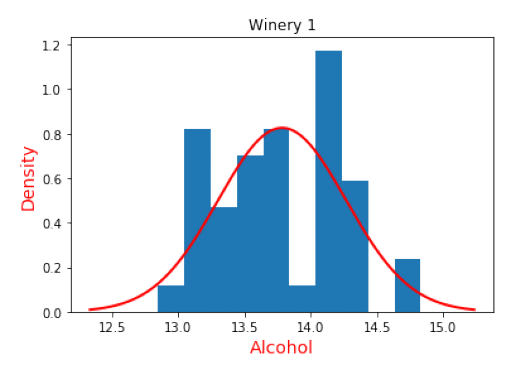

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f"{local_folder}histogram.png"
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')  # Oculta os eixos
plt.show()

Hmm: how can we generate a figure like this?

The following function, **density_plot**, does this for any feature and label. The first line adds an interactive component that lets you choose these parameters using sliders.

<font color="magenta">Try it out!</font> And then, look at the code carefully to understand exactly what it is doing, line by line.

In [6]:
@interact_manual( feature=IntSlider(0,0,12), label=IntSlider(1,1,3))
def density_plot(feature, label):
    plt.hist(trainx[trainy==label,feature], density=True)
    #
    mu = np.mean(trainx[trainy==label,feature]) # mean
    var = np.var(trainx[trainy==label,feature]) # variance
    std = np.sqrt(var) # standard deviation
    #
    x_axis = np.linspace(mu - 2*std, mu + 2*std, 1000)
    plt.plot(x_axis, norm.pdf(x_axis,mu,std), 'r', lw=2)
    plt.title("Winery "+str(label) )
    plt.xlabel(featurenames[feature], fontsize=14, color='red')
    plt.ylabel('Density', fontsize=14, color='red')
    plt.show()

interactive(children=(IntSlider(value=0, description='feature', max=12), IntSlider(value=1, description='label…

### <font color="magenta">Fast exercise</font>

In the function **density_plot**, the code for plotting the Gaussian density focuses on the region within 3 standard deviations of the mean. Do you see where this happens? Why do you think we make this choice?

Here's something for you to figure out: for which feature (0-12) does the distribution of (training set) values for winery 1 have the *smallest* standard deviation? Write down the answer: you will need to enter it as part of this week's programming assignment.

In [7]:
# modify this cell
std = np.zeros(13)
smallest_standard_deviation_feature = [np.std(trainx[trainy==1,0]),0]
for feature in range(1,13):
    std[feature] = np.std(trainx[trainy==1,feature])
    if (std[feature] < smallest_standard_deviation_feature[0]):
      smallest_standard_deviation_feature = [std[feature],feature]
print(f'{smallest_standard_deviation_feature[1]} - {featurenames[smallest_standard_deviation_feature[1]]}')

7 - Nonflavanoid phenols


## 3. Fit a Gaussian to each class

Let's define a function that will fit a Gaussian generative model to the three classes, restricted to just a single feature.

In [8]:
# Assumes y takes on values 1,2,3
def fit_generative_model(x,y,feature):
    k = 3 # number of classes
    mu = np.zeros(k+1) # list of means
    var = np.zeros(k+1) # list of variances
    pi = np.zeros(k+1) # list of class weights
    for label in range(1,k+1):
        indices = (y==label)
        mu[label] = np.mean(x[indices,feature])
        var[label] = np.var(x[indices,feature])
        pi[label] = float(sum(indices))/float(len(y))
    return mu, var, pi

Call this function on the feature 'alcohol'. What are the class weights?

In [9]:
feature = 0 # 'alcohol'
mu, var, pi = fit_generative_model(trainx, trainy, feature)
print(pi[1:])

[0.33076923 0.41538462 0.25384615]


Next, display the Gaussian distribution for each of the three classes

In [10]:
@interact_manual( feature=IntSlider(0,0,12) )
def show_densities(feature):
    mu, var, pi = fit_generative_model(trainx, trainy, feature)
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        m = mu[label]
        s = np.sqrt(var[label])
        x_axis = np.linspace(m - 3*s, m+3*s, 1000)
        plt.plot(x_axis, norm.pdf(x_axis,m,s), colors[label-1], label="class " + str(label))
    plt.xlabel(featurenames[feature], fontsize=14, color='red')
    plt.ylabel('Density', fontsize=14, color='red')
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=0, description='feature', max=12), Button(description='Run Interact', st…

### <font color="magenta">Fast exercise</font>

Use the widget above to look at the three class densities for each of the 13 features. Here are some questions for you:
* For which feature (0-12) do the densities for classes 1 and 3 *overlap* the most?
* For which feature (0-12) is class 3 the most spread out relative to the other two classes?
* For which feature (0-12) do the three classes seem the most *separated* (this is somewhat subjective at present)?

*Write down the answers to these questions: you will enter them as part of this week's assignment.*

In [ ]:
mu_compare, var_compare, p_compare = fit_generative_model(trainx, trainy, 0)

overlap_compare_calc = abs(mu_compare[0]-mu_compare[2])/(var_compare[0]+var_compare[2])
separated_compare_calc = (abs(mu_compare[0]-mu_compare[1])+abs(mu_compare[1]-mu_compare[2])+abs(mu_compare[0]-mu_compare[2]))/(var_compare[0]+var_compare[1]+var_compare[2])


density_overlap_most = [overlap_compare_calc,0]
spread_most = [(var_compare[2]-((var_compare[0]+var_compare[1])/2)), 0]
separated_most = [separated_compare_calc, 0]

for feature in range(1, len(featurenames)):
  mu, var, pi = fit_generative_model(trainx, trainy, feature)
  overlap_nw_calc = abs(mu[0]-mu[2])/(var[0]+var[2])
  spread_most_nw_calc  = var[2]-((var[0]+var[1])/2)
  separated_nw_calc = (abs(mu[0]-mu[1])+abs(mu[1]-mu[2])+abs(mu[0]-mu[2]))/(var[0]+var[1]+var[2])

  if(density_overlap_most[0] > overlap_nw_calc):
    density_overlap_most = [overlap_nw_calc,feature]

  if(spread_most[0] > spread_most_nw_calc):
    spread_most = [spread_most_nw_calc, feature]

  if(separated_most[0] > separated_nw_calc):
    separated_most = [separated_nw_calc, feature]


print(f'Feature which the densities for classes 1 and 3 overlap the most: {density_overlap_most[1]} - {featurenames[density_overlap_most[1]]} = {density_overlap_most[0]}')
print(f'Feature which is class 3 the most spread out relative to the other two classes: {spread_most[1]} - {featurenames[spread_most[1]]} = {spread_most[0]}')
print(f'Feature which the three classes seem the most separated: {separated_most[1]} - {featurenames[separated_most[1]]} = {separated_most[0]}')

Feature which the densities for classes 1 and 3 overlap the most: 12 - Proline = 0.02088082819516954
Feature which is class 3 the most spread out relative to the other two classes: 7 - Nonflavanoid phenols = 0.013688715436587156
Feature which the three classes seem the most separated: 12 - Proline = 0.031015144893261723


## 4. Predict labels for the test set

How well can we predict the class (1,2,3) based just on one feature? The code below lets us find this out.

In [ ]:
@interact( feature=IntSlider(0,0,12) )
def test_model(feature):
    mu, var, pi = fit_generative_model(trainx, trainy, feature)

    k = 3 # Labels 1,2,...,k
    n_test = len(testy) # Number of test points
    score = np.zeros((n_test,k+1))
    for i in range(0,n_test):
        for label in range(1,k+1):
            score[i,label] = np.log(pi[label]) + \
            norm.logpdf(testx[i,feature], mu[label], np.sqrt(var[label]))
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    # Finally, tally up score
    errors = np.sum(predictions != testy)
    print("Test error using feature " + featurenames[feature] + ": " + str(errors) + "/" + str(n_test))

interactive(children=(IntSlider(value=0, description='feature', max=12), Output()), _dom_classes=('widget-inte…

### <font color="magenta">One last exercise</font>

In this notebook, we are looking at classifiers that use just one out of a possible 13 features. Choosing a subset of features is called **feature selection**. In general, this is something we would need to do based solely on the *training set*--that is, without peeking at the *test set*.

For the wine data, compute the training error and test error associated with each choice of feature.

In [19]:
from scipy.stats import norm
import numpy as np

def get_best_model():
    feature_n = len(featurenames)
    k = 3

    training_errors = []
    test_errors = []

    for feature in range(feature_n):
        # Treina o modelo usando apenas essa feature
        mu, var, pi = fit_generative_model(trainx, trainy, feature)

        #Train set
        train_scores = np.zeros((len(trainy), k + 1))
        for i in range(len(trainy)):
            for label in range(1, k + 1):
                train_scores[i, label] = np.log(pi[label]) + \
                    norm.logpdf(trainx[i, feature], mu[label], np.sqrt(var[label]))
        train_predictions = np.argmax(train_scores[:, 1:], axis=1) + 1
        train_error = np.mean(train_predictions != trainy)
        training_errors.append((feature, train_error))

        #Test Set
        test_scores = np.zeros((len(testy), k + 1))
        for i in range(len(testy)):
            for label in range(1, k + 1):
                test_scores[i, label] = np.log(pi[label]) + \
                    norm.logpdf(testx[i, feature], mu[label], np.sqrt(var[label]))
        test_predictions = np.argmax(test_scores[:, 1:], axis=1) + 1
        test_error = np.mean(test_predictions != testy)
        test_errors.append((feature, test_error))

    sorted_train = sorted(training_errors, key=lambda x: x[1])
    sorted_test = sorted(test_errors, key=lambda x: x[1])

    print("Top 3 features with the lowest training error:")
    for feature_idx, error in sorted_train[:3]:
        print(f"- {featurenames[feature_idx]} (Error: {error:.4f})")

    print("\nTop 3 features with the lowest test error:")
    for feature_idx, error in sorted_test[:3]:
        print(f"- {featurenames[feature_idx]} (Error: {error:.4f})")

get_best_model()

Top 3 features with the lowest training error:
- Flavanoids (Error: 0.2077)
- Proline (Error: 0.2692)
- Color intensity (Error: 0.2923)

Top 3 features with the lowest test error:
- Flavanoids (Error: 0.1667)
- Color intensity (Error: 0.2083)
- Hue (Error: 0.2917)


Based on your findings, answer the following questions:
* Which three features have the lowest training error? List them in order (best first).
* Which three features have the lowest test error? List them in order (best first).

*Note down your answers: you will enter them later, as part of this week's programming assignment*.